In [63]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

In [15]:
df=pd.read_csv("C:\\Users\\admin\\OneDrive\\Desktop\\Accredian\\Fraud.csv")

# 1-DATA CHECKS & CLEANING

In [21]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [25]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [27]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [39]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("dtypes:\n", df.dtypes.value_counts())
print("Missing values (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))

Shape: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
dtypes:
 float64    5
int64      3
object     3
Name: count, dtype: int64
Missing values (top 10):
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


### Feature engineering (only if columns exist)

In [41]:
def safe_diff(colA, colB):
    return (df[colA] if colA in df.columns else 0) - (df[colB] if colB in df.columns else 0)

if all(c in df.columns for c in ["oldbalanceOrg","newbalanceOrig","amount"]):
    df["deltaOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]
    df["errorOrig"] = df["newbalanceOrig"] + df["amount"] - df["oldbalanceOrg"]
if all(c in df.columns for c in ["newbalanceDest","oldbalanceDest","amount"]):
    df["deltaDest"] = df["newbalanceDest"] - df["oldbalanceDest"] - df["amount"]
    df["errorDest"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]
if all(c in df.columns for c in ["oldbalanceOrg","newbalanceOrig","newbalanceDest","oldbalanceDest"]):
    df["balanceDiff"] = (df["oldbalanceOrg"] - df["newbalanceOrig"]) - (df["newbalanceDest"] - df["oldbalanceDest"])

### Drop obvious IDs if present

In [51]:
for col in ["nameOrig","nameDest"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

### Winsorize numeric outliers (IQR caps)

In [54]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if "isFraud" in num_cols_all:
    num_cols_all = [c for c in num_cols_all if c not in ["isFraud","isFlaggedFraud"]]

def winsorize_iqr(frame, cols):
    frame = frame.copy()
    for c in cols:
        x = frame[c].values
        if np.isfinite(x).sum() == 0: 
            continue
        q1, q3 = np.nanpercentile(x, [25, 75])
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        frame[c] = np.clip(x, low, high)
    return frame

df = winsorize_iqr(df, num_cols_all)

### Remove infs & fill tiny NaNs (rare)

In [57]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df[num_cols_all] = df[num_cols_all].fillna(0.0)


# 2-MULTICOLLINEARITY (VIF via sklearn)

In [65]:
def compute_vif_sklearn(data, cols):
    vif = []
    X_all = data[cols].values
    for i, col in enumerate(cols):
        y = X_all[:, i]
        X = np.delete(X_all, i, axis=1)
        if X.shape[1] == 0:
            vif.append((col, 1.0))
            continue
        # Guard against constant columns
        if np.allclose(X.std(axis=0), 0):
            vif.append((col, np.inf))
            continue
        lr = LinearRegression()
        lr.fit(X, y)
        r2 = lr.score(X, y)
        vif_val = np.inf if r2 >= 0.999999 else 1.0 / max(1e-9, (1.0 - r2))
        vif.append((col, vif_val))
    return pd.DataFrame(vif, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

num_for_vif = [c for c in num_cols_all if df[c].std() > 0]
to_drop = []
# Iteratively drop highest VIF > 10
while True:
    if len(num_for_vif) <= 1:
        break
    vif_df = compute_vif_sklearn(df, num_for_vif)
    top_feat, top_vif = vif_df.iloc[0]["feature"], vif_df.iloc[0]["VIF"]
    if not np.isfinite(top_vif) or top_vif > 10:
        to_drop.append(top_feat)
        num_for_vif.remove(top_feat)
    else:
        break

print("Dropped for VIF (>10):", to_drop if to_drop else "None")


Dropped for VIF (>10): ['deltaOrig', 'deltaDest', 'newbalanceDest', 'amount']


# 3-DEFINE FEATURES/TARGET & TRAIN/VALID SPLIT

In [67]:
target_col = "isFraud"
if target_col not in df.columns:
    raise ValueError("Column 'isFraud' not found in your CSV. Please check the dataset.")

# Categorical columns: default to 'type' if present; otherwise any object/category columns
if "type" in df.columns:
    cat_cols = ["type"]
else:
    cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# Final numeric set after VIF pruning
num_cols = [c for c in num_for_vif if c in df.columns]

# Build X, y (only keep columns that exist)
use_cols = [c for c in (cat_cols + num_cols) if c in df.columns]
X = df[use_cols].copy()
y = df[target_col].astype(int).copy()

# Handle rare case: no categorical columns
if len(cat_cols) == 0:
    preprocess = ColumnTransformer([
        ("scale", StandardScaler(with_mean=False), num_cols)
    ], remainder="drop")
else:
    preprocess = ColumnTransformer([
        ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("scale", StandardScaler(with_mean=False), num_cols)
    ], remainder="drop")

# Train/valid split (stratified)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Class balance (train):", Counter(y_train))
print("Class balance (valid):", Counter(y_valid))

Class balance (train): Counter({0: 5083526, 1: 6570})
Class balance (valid): Counter({0: 1270881, 1: 1643})


# 4-MODELS & EVALUATION

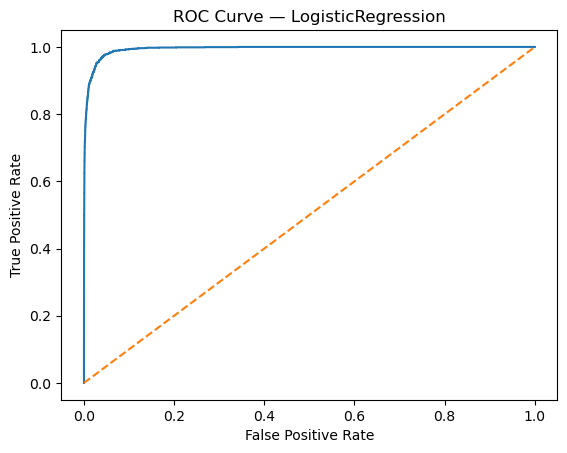

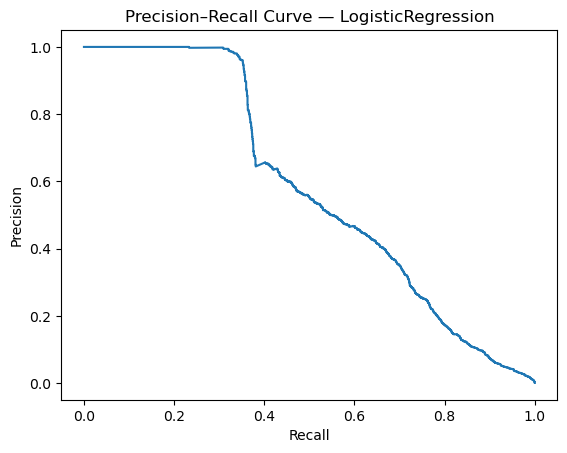

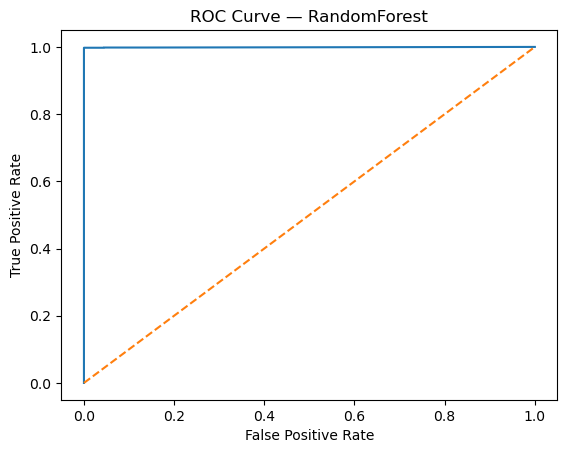

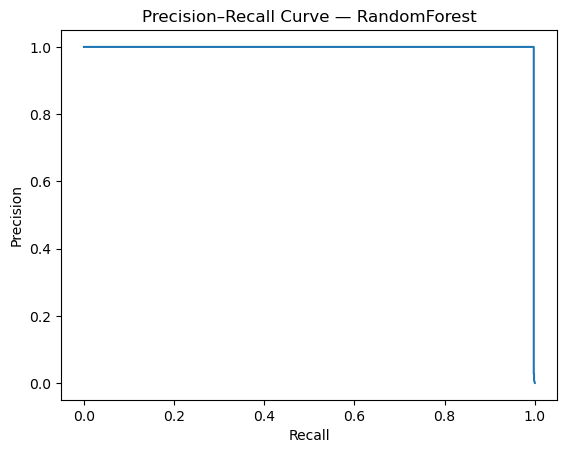


=== Best model: RandomForest ===
ROC AUC: 0.9989 | PR AUC: 0.9976
Chosen threshold: 0.1177 → Precision=0.9001, Recall=0.9976
Confusion Matrix @ tuned threshold:
 [[1270699     182]
 [      4    1639]]
Classification report @ tuned threshold:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000   1270881
           1      0.900     0.998     0.946      1643

    accuracy                          1.000   1272524
   macro avg      0.950     0.999     0.973   1272524
weighted avg      1.000     1.000     1.000   1272524



In [71]:
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=150, random_state=42, class_weight="balanced", n_jobs=-1
    ))
])

models = {"LogisticRegression": log_reg, "RandomForest": rf}
results = {}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    proba = mdl.predict_proba(X_valid)[:, 1]
    roc = roc_auc_score(y_valid, proba)
    ap = average_precision_score(y_valid, proba)
    fpr, tpr, _ = roc_curve(y_valid, proba)
    prec, rec, th = precision_recall_curve(y_valid, proba)

    # Threshold: target >= 0.90 precision if feasible; fallback best F1
    cand = [(p, r, t) for p, r, t in zip(prec[:-1], rec[:-1], th) if p >= 0.90]
    if len(cand) > 0:
        best_p, best_r, best_t = max(cand, key=lambda x: x[1])
    else:
        f1 = 2*(prec*rec)/(prec+rec+1e-9)
        idx = int(np.nanargmax(f1))
        best_p, best_r, best_t = prec[idx], rec[idx], th[max(0, idx-1)]

    preds = (proba >= best_t).astype(int)
    cm = confusion_matrix(y_valid, preds)
    report = classification_report(y_valid, preds, digits=3, zero_division=0)

    results[name] = dict(
        roc_auc=roc, ap=ap, best_t=best_t, best_p=best_p, best_r=best_r,
        confusion_matrix=cm, report=report, proba=proba
    )

    # Plots (matplotlib only; seaborn not required)
    plt.figure()
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {name}")
    plt.show()

    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve — {name}")
    plt.show()

# Pick best by PR AUC (more informative for imbalanced data)
best_name = max(results, key=lambda k: results[k]["ap"])
best = results[best_name]
print(f"\n=== Best model: {best_name} ===")
print(f"ROC AUC: {best['roc_auc']:.4f} | PR AUC: {best['ap']:.4f}")
print(f"Chosen threshold: {best['best_t']:.4f} → Precision={best['best_p']:.4f}, Recall={best['best_r']:.4f}")
print("Confusion Matrix @ tuned threshold:\n", best["confusion_matrix"])
print("Classification report @ tuned threshold:\n", best["report"])


# 5-KEY FACTORS (Permutation Importance)


Top features (Permutation Importance):
           feature  importance
5       errorOrig    0.073678
3  newbalanceOrig    0.026481
0            type    0.000469
7     balanceDiff    0.000022
4  oldbalanceDest    0.000018
2   oldbalanceOrg    0.000013
6       errorDest    0.000003
1            step    0.000002


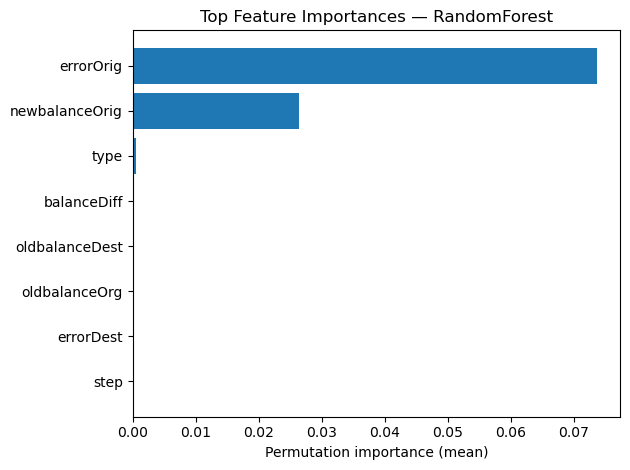

In [76]:
best_model = models[best_name]
perm = permutation_importance(best_model, X_valid, y_valid, n_repeats=3, random_state=42, n_jobs=1)
imp_df = pd.DataFrame({
    "feature": list(X_valid.columns),
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)
print("\nTop features (Permutation Importance):\n", imp_df.head(12))

# Optional: visualize top features
topN = imp_df.head(15).iloc[::-1]
plt.figure()
plt.barh(topN["feature"], topN["importance"])
plt.xlabel("Permutation importance (mean)")
plt.title(f"Top Feature Importances — {best_name}")
plt.tight_layout()
plt.show()


# 6-SHORT, ACTIONABLE TAKEAWAYS

In [75]:
print("\nQuick takeaways:")
print("- Balance-consistency features like delta/error terms are typically strong signals if present.")
print("- TRANSFER/CASH_OUT (if 'type' is available) usually carries higher risk than PAYMENT.")
print("- Use the tuned threshold above in production to trade recall for high precision (fewer false positives).")


Quick takeaways:
- Balance-consistency features like delta/error terms are typically strong signals if present.
- TRANSFER/CASH_OUT (if 'type' is available) usually carries higher risk than PAYMENT.
- Use the tuned threshold above in production to trade recall for high precision (fewer false positives).
